<a href="https://colab.research.google.com/github/xChrislinex/MyVeryFirstRepo/blob/main/Kopia_notatnika_Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from os import path

# nazwa archiwum do dostosowania
!unzip '/content/drive/MyDrive/archive.zip'

KeyboardInterrupt: ignored

In [17]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import img_to_array, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [2]:
main_folder = '../content/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [3]:
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [4]:
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

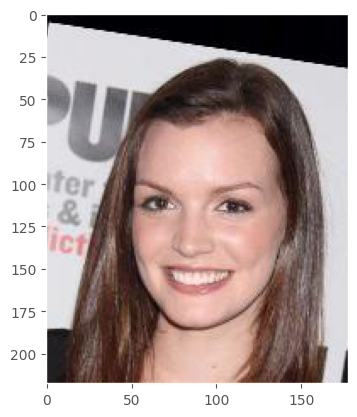

In [5]:
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

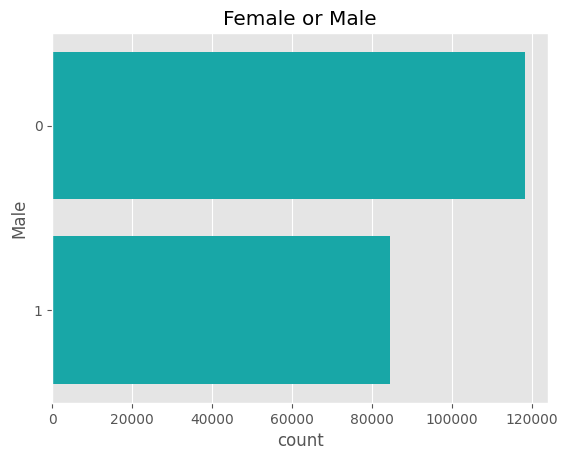

In [6]:
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [7]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [9]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test

    '''

    df_ = df_par_attr[(df_par_attr['partition'] == partition)
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition)
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

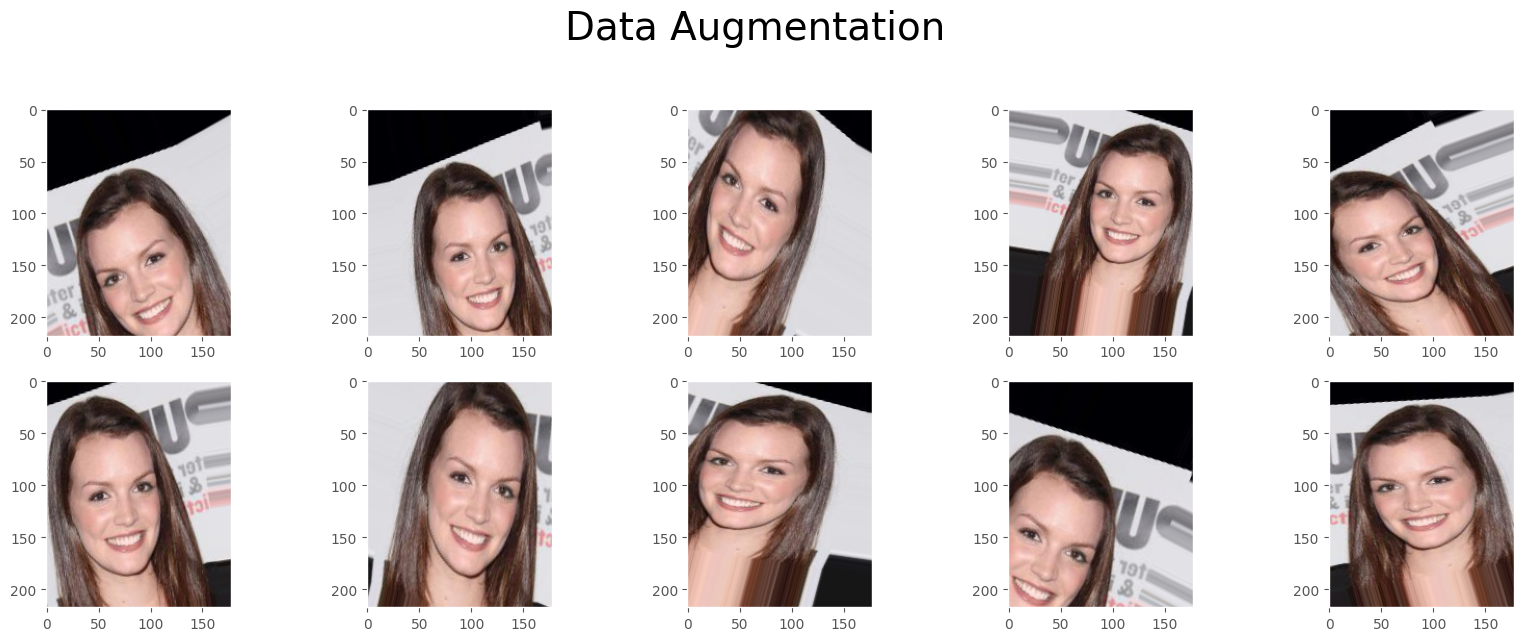

In [11]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))

    if i == 9:
        break
    i += 1

plt.show()

In [12]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# # Train - Data Preparation - Data Augmentation with generators
# train_datagen =  ImageDataGenerator(
#   preprocessing_function=preprocess_input,
#   rotation_range=30,
#   width_shift_range=0.2,
#   height_shift_range=0.2,
#   shear_range=0.2,
#   zoom_range=0.2,
#   horizontal_flip=True,
# )

# train_datagen.fit(x_train)

# train_generator = train_datagen.flow(
# x_train, y_train,
# batch_size=BATCH_SIZE,
# )

In [13]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

kernel_s =(3,3)

model= Sequential()
model.add(Conv2D(32,kernel_s,activation='relu',input_shape=(178,218,3),
                        padding="VALID"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,kernel_s,activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_s,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,kernel_s,activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,kernel_s,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 176, 216, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 88, 108, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 106, 64)       18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 51, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 25, 64)      

In [33]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [ ]:
history = model.fit(
    x_train,
    validation_data=(x_valid,y_valid),
    epochs=50
)